## Introduction to Random Forest

Random forest is an ensemble learning method that uses a host (`forest`) of simple (usually low-depth) decision trees. It uses the prediction outcome from each such trees and combines them to form the final prediction.

### Decision Trees

Decision trees are representation of a series of if-else statements. An example is below

<img src="resources/trees.png" width="20%" height="20%">

Here, starting from the root node, each non-leaf (terminating) nodes represent a question or an if-else check. Depending on the answer, the output can go into either of the braches. The final nodes (leaf nodes) represent the outcome. If the outcomes represent categorical variables (or classes), it is called a `classification tree`, else for continous outcome, it is known as `regression tree`. The equivalent statement for the above decision tree is:

```python

if A:
    return B
else:
    if C:
        return D
    else:
        return E
```

If the logic is already available, like the values of parameters (conditions A and C) and the outcomes (B, D and E), then it is straight-forward (and faster) to write the above if-else statement for evaluation.

When we do not know the parameters and the outcomes, but have to learn from the data, the tree represents an easier to handle data structure to run the usual optimization techniques in a systematic manner.

Random Forest uses the ensememble methods using a collection of decision trees as base learners. Each of the trees are simultaneously (and conditionally) trained. And their individual predictions (outcomes) are combined to form the final predictions. So in essense, a random forest looks like below:

<img src="resources/rf.png" width="50%" height="50%">

### Random Forest Building and Training

Given we first need to decide how to build the individual trees and then how to combine them, building random forest can be a bit challenging.

#### Defining the Individual Trees

Here we need to know how to frame the `if-else` condition for each node for a tree. This is usually based on a node splitting `criterion`. Remember we do not know the parameters (the condition A above, for example) and need to infer that from the data. To do that during the training, we decide how to split the cases. The [gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) or the [entropy](https://en.wikipedia.org/wiki/Decision_tree_learning#Information_gain) are usually two popular ways to do so.

The next thing we need to decide, how deep we can allow to grow each tree - this is controlled by `max_depth` feature. Usually, a deep tree will have less number of cases at its nodes (as it was split too many times, each time reducing the cases that pass the condition at that node from either side). A deep tree results in over-fitting the tree during training. But note: in case of random forest, overfitting of individual trees are not a concern. Infact, we expect them to overfit. Taking the average (or some sort of voting) over the whole forest means random overfitting should be averaged out. However, deep tree will increase computation time of course. And some researches reported low depths works better in some cases. I sugges keep a lower depth and increase the number of trees instead. This makes sure each node see multiple cases.

Final important paramter is the number of (pre-selected) features to consider for node split - `max_features`. Usually it is better to keep this number lower than whole set of available features. So that many trees see only a sample, and a single dominant feature does not dictate all trees. As a result, the overall forest can exploit more information hidden in the feature vectors.

#### Defining the Forest

Once we defined how the individual trees are to be built, next we to specify how to build the forest itself. The most important is the number of trees we require (`n_estimators`). Usually the more, the better. However of course they come at a cost of computation. There are many other parameters, for a complete list see the sklearn [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).


The forest then gets trained on the input cases, the trees are built and the errors from the combined predictions are optimized (instead of errors from individual trees) against the given target. 

### Using Sklearn Framework for Random Forest

In Python, perhaps the simplest way to use a random forest in your machine learning problem is to use the implementation from sklearn. Make sure you are choosing the paramteres wisely. Also the input features must be well chosen and well behaved. We try out a toy example with the famous [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) data-set.

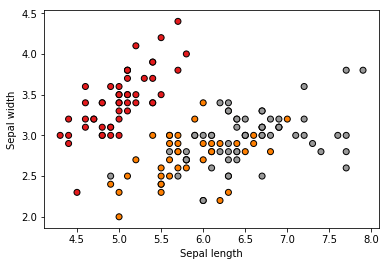

In [2]:
import matplotlib.pyplot as plt
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.show()

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=42)
rf.fit(X_train,y_train)

score1 = rf.score(X_train,y_train)
score2 = rf.score(X_test,y_test)
print(f'training score is {score1} and test score is {score2}')

training score is 0.78 and test score is 0.8


## Random Forest for Trading

Let's now apply a random forest model for trading. We develop and test a very simple strategy to trade a single stock. We fix the stock at the beginnng. At certain interval, we train a model based on data inputs we think are relevant. Then we use the model to take position (buy or sell) in the stock - based on the model prediction. If we do better than a random trading rule, we are happy. The overall flow of the process is as below

<img src="resources/ml_workflow.jpg" width="50%" height="50%">


### Data Generation

Selecting features for our model requires some expertise in financial markets. If you are an expert trader, you can perhaps look at a chart and anticipate the next move. Here we are trying to teach a model to predict the next move. For that we need to decide what we feed to the model. Note: unlike general purpose machine learning - complex data transformation (e.g. convolution) is usually not part of the model itself. We have to explicitly transform any data we need to. Also, the data must be recent, relevant and `stationary`[?]. The mostly used data types for a financial trading/ investing model are:

- Price data or transformation of price data – e.g. OHLC ratios, technical indicators. Can we use price? Or any technical indicators?

- Fundamental data – like valuation ratios, or economic indicators – make sure they are stationary

- Sentiment data – like news reports, company annual reports tone, social media sentiments on the stock or the company’s product(s)

- Alternative data – cars in the parking lot? 


### Train the Model - Classification or Regression?

Before we train, we must decide what is our objective. `Classification` can be a natural choice for certain strategy - e.g. where we are trading with a fixed capital and interested to know the action (buy/ sell/ hold). Or say we are trying to identify the phase of the market, is it bullish, or bearish or sideways. Given the usually high level of noise vs. signal in financial data inputs, classification is often preferred. If we can transform a problem to a classification class, we should stick to it.

However, `regression` is the only choice if we are developing a model say to determine asset allocation, or position sizing – where it is impossible to convert in to a classification. The target state-space is naturally continuous (real-valued instead of `classes`) in these cases.


### Test the Mode

This is also a markedly different phase. Most professionals prefer to do a `backtest`. A backtest is testing the model prediction by actually simulating trading based on the model prediction over a continuous period of time in history. 

### Test-Train Split

For testing a model, we usually randomly split the available dataset into a `train` dataset and a `test` dataset (in addition to a `validation` dataset which is used during training). The first is used to train the model, the second is used to evaluate the model. However, for financial dataset, we cannot do a random splitting. The temporal characteristics are very important features of a financial series (time-series in general). Hence, we take a set of continuous samples as training dataset and the rest as test dataset. This can be a problem if training dataset spans a long history or too back-dated to be relevant in the test period. To overcome this, many times we do the model training and testing together. We run a backtest where we periodically build the model. Then for next few periods we use the model prediction and collect the peformance data. Then train the model. This continues until the end.

Let's now build the model and test it.

In [4]:
# first we get some data
import numpy as np
import pandas as pd

df = pd.read_csv('data/data.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)

df.tail()

,open,high,low,close,volume
Date,,,,,
2021-03-16,2114.00,2126.00,2095.50,2100.60,6402757
2021-03-17,2098.05,2103.00,2035.10,2055.35,8865521
2021-03-18,2072.90,2084.80,2001.00,2009.10,9528809
2021-03-19,1991.00,2095.85,1982.80,2082.00,19284892
2021-03-22,2071.00,2074.00,2035.35,2062.40,8569337


In [5]:
# now let's generate the features. We will use TA-lib - a C library for technical indicators
# to generate features for out data

import talib as ta

features = {}
features['roc1'] = ta.ROC(df.close, timeperiod=5)
features['roc2'] = ta.ROC(df.close, timeperiod=20)
features['rsi1'] = ta.RSI(df.close, timeperiod=14)
features['rsi2'] = ta.RSI(df.close, timeperiod=28)
features['cci1'] = ta.CCI(df.high, df.low, df.close, timeperiod=14)
features['cci2'] = ta.CCI(df.high, df.low, df.close, timeperiod=28)
features['adx1'] = ta.ADX(df.high, df.low, df.close, timeperiod=14)
features['adx2'] = ta.ADX(df.high, df.low, df.close, timeperiod=28)
features['atr'] = ta.ATR(df.high, df.low, df.close, timeperiod=14)
features['aroon1'] = ta.AROONOSC(df.high, df.low, timeperiod=14)
features['aroon2'] = ta.AROONOSC(df.high, df.low, timeperiod=28)
features['bop'] = ta.BOP(df.open, df.high, df.low, df.close)
features['cmo'] = ta.CMO(df.close, timeperiod=14)

features = pd.DataFrame(features, index=df.index)
n_features = len(features.columns)

features.tail()

,roc1,roc2,rsi1,rsi2,cci1,cci2,adx1,adx2,atr,aroon1,aroon2,bop,cmo
Date,,,,,,,,,,,,,
2021-03-16,-4.130345,3.345469,51.208444,53.190885,-52.484021,31.576036,26.037803,13.984547,59.207942,64.285714,82.142857,-0.439344,2.416888
2021-03-17,-6.193378,-0.201505,45.421214,50.194778,-127.802389,-19.334216,24.773152,13.489923,59.828803,57.142857,78.571429,-0.628866,-9.157571
2021-03-18,-7.921813,-3.559342,40.396095,47.366766,-147.769273,-63.737282,24.179578,13.171509,61.541031,-50.000000,75.000000,-0.761337,-19.207810
2021-03-19,-2.601048,0.691590,49.819778,51.805230,-104.543582,-44.906243,23.917841,12.950933,65.220243,-57.142857,64.285714,0.804954,-0.360443
2021-03-22,-2.204941,-0.860453,47.638951,50.615151,-91.515207,-47.020547,23.674799,12.738234,63.893797,-57.142857,64.285714,-0.222510,-4.722099


In [6]:
# We will be training and use prediction from the model together
# let's squash the data and features together

data = pd.concat([df, features], axis=1)

# we add an column to keep track of our trading positions later
data['pos'] = 0

print(data.shape)
data.tail()

(2462, 19)


,open,high,low,close,volume,roc1,roc2,rsi1,rsi2,cci1,cci2,adx1,adx2,atr,aroon1,aroon2,bop,cmo,pos
Date,,,,,,,,,,,,,,,,,,,
2021-03-16,2114.00,2126.00,2095.50,2100.60,6402757,-4.130345,3.345469,51.208444,53.190885,-52.484021,31.576036,26.037803,13.984547,59.207942,64.285714,82.142857,-0.439344,2.416888,0
2021-03-17,2098.05,2103.00,2035.10,2055.35,8865521,-6.193378,-0.201505,45.421214,50.194778,-127.802389,-19.334216,24.773152,13.489923,59.828803,57.142857,78.571429,-0.628866,-9.157571,0
2021-03-18,2072.90,2084.80,2001.00,2009.10,9528809,-7.921813,-3.559342,40.396095,47.366766,-147.769273,-63.737282,24.179578,13.171509,61.541031,-50.000000,75.000000,-0.761337,-19.207810,0
2021-03-19,1991.00,2095.85,1982.80,2082.00,19284892,-2.601048,0.691590,49.819778,51.805230,-104.543582,-44.906243,23.917841,12.950933,65.220243,-57.142857,64.285714,0.804954,-0.360443,0
2021-03-22,2071.00,2074.00,2035.35,2062.40,8569337,-2.204941,-0.860453,47.638951,50.615151,-91.515207,-47.020547,23.674799,12.738234,63.893797,-57.142857,64.285714,-0.222510,-4.722099,0


In [7]:
# Now we build the model
# In our case, we are interested to know if we should buy or sell the stock
# So, we have a classification problem at hand

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, max_depth=3, max_features=0.5, random_state=42)

In [8]:
# our training target is next N-day performance 1 if positive or 0 if negative
# we define our strategy parameters and compute target based on strategy horizon - 20 days

N = 20
total_days = len(data)
starting_pos = 2000
batch_size = 200
feature_cols_start = 5

target = ta.ROC(data.close, N)
target.loc[target>0] = 1
target.loc[target<=0] = 0
target = target.fillna(0)
target = target.astype('int32')
target.tail()

Date
2021-03-16    1
2021-03-17    0
2021-03-18    0
2021-03-19    1
2021-03-22    0
dtype: int32

In [9]:
# Now we iterate through our data
# We evaluate our model every N-th day
import tqdm

def train_model(model, data, target, start, end, feature_cols_start):
    X_train = data.iloc[start:end, feature_cols_start:-1]
    Y_train = target.iloc[start:end]
    model.fit(X_train, Y_train)
    return model

for i in tqdm.tqdm(range(starting_pos, total_days)):
    end = i-1
    start = end - batch_size
    
    if i%N ==0:
        rf = train_model(rf, data, target, start, end, feature_cols_start)
    
    features = data.iloc[i,feature_cols_start:-1]
    pos = rf.predict(features.values.reshape((1,n_features)))
    data.iloc[i,18] = pos[0]

data.tail()

100%|████████████████████████████████████████████████████████████████████████████████| 462/462 [01:37<00:00,  4.76it/s]


,open,high,low,close,volume,roc1,roc2,rsi1,rsi2,cci1,cci2,adx1,adx2,atr,aroon1,aroon2,bop,cmo,pos
Date,,,,,,,,,,,,,,,,,,,
2021-03-16,2114.00,2126.00,2095.50,2100.60,6402757,-4.130345,3.345469,51.208444,53.190885,-52.484021,31.576036,26.037803,13.984547,59.207942,64.285714,82.142857,-0.439344,2.416888,1
2021-03-17,2098.05,2103.00,2035.10,2055.35,8865521,-6.193378,-0.201505,45.421214,50.194778,-127.802389,-19.334216,24.773152,13.489923,59.828803,57.142857,78.571429,-0.628866,-9.157571,0
2021-03-18,2072.90,2084.80,2001.00,2009.10,9528809,-7.921813,-3.559342,40.396095,47.366766,-147.769273,-63.737282,24.179578,13.171509,61.541031,-50.000000,75.000000,-0.761337,-19.207810,0
2021-03-19,1991.00,2095.85,1982.80,2082.00,19284892,-2.601048,0.691590,49.819778,51.805230,-104.543582,-44.906243,23.917841,12.950933,65.220243,-57.142857,64.285714,0.804954,-0.360443,1
2021-03-22,2071.00,2074.00,2035.35,2062.40,8569337,-2.204941,-0.860453,47.638951,50.615151,-91.515207,-47.020547,23.674799,12.738234,63.893797,-57.142857,64.285714,-0.222510,-4.722099,0


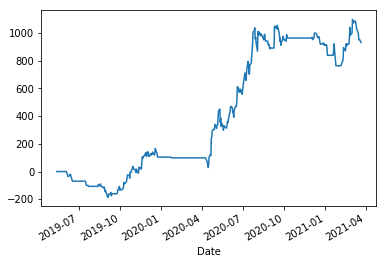

In [10]:
returns = df.close - df.close.shift(1)

perfs = data.pos.shift(1)*returns
perfs = perfs[perfs.index > data.index[starting_pos]]
perfs.cumsum().plot()

### Doing Better

We have cut outselves some serious slacks in this demo. The major issue our backtest suffers is a possibility of [lookahead bias](https://www.investopedia.com/terms/l/lookaheadbias.asp). It comes from the fact that we have computed all our signals at one go (vectorized). To safeguard against it, we need an `event-driven` backtest. It is more accurate, but painful to develop the codes around it. Fortunately there are readymade libraries (like `zipline`) or platforms (like [blueshift](https://blueshift.quantinsti.com/)) that we can use. Also note that we have used a cumulative sum for calculation of our performance. This assumes a constant rebalance of capital each day, which is not practical[?]. Also, we have used only a single stock and somehow avoided the 2020 crash and rode the subsequent bull market. There is a chance we just got lucky!

Real-life trading system will almost always have 

- A much larger universe, sometimes 100s of stocks or other asset classes.
- A more thorough research for feature selections, that probably will include fundamental data (like P/E ratios) and other alternate data sources.
- Some sort of hyperparameter tuning - we just assumed some parameters.
- Some limited optimization and risk management - we had no optimization, and zero risk management built into the model. However, optimization can be counter-productive as well, especially in financial markets with limited data.
- An adaptive modelling - we assume fixed rebalance and training

